In [1]:
import sys, os
sys.path.append("../src/models/")
sys.path.append("../src/")

from argparse import ArgumentParser
import yaml, os
from datasets.mrc import MRCImageDataModule, MRCImageDataset, remove_padding, get_minmax_xy_of_non_padding
from models.srgan import SRGAN, DATATYPE
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm

import mrcfile
import matplotlib.pyplot as plt
    

/home/kyohei/miniconda3/envs/cryoem/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:35: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/kyohei/miniconda3/envs/cryoem/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:93: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task

In [2]:
train_or_test = "train"

In [3]:
dm = MRCImageDataModule(
    "/media/kyohei/forAI/split_images/",
    datatype=DATATYPE,
    batch_size=100,
    datasize="all",
    split_way="images",
)
dm.setup()

if train_or_test=="test":
    dataset_indices = dm.mrc_test_dataset.indices
else:
    dataset_indices = list(range(len(dm.mrc_dataset)))
    dataset_indices = [i for i in dataset_indices if i not in dm.mrc_test_dataset.indices]

xx_test = [dm.mrc_dataset.short_list[ind] for ind in dataset_indices]
ytrue_test = [dm.mrc_dataset.original_list[ind] for ind in dataset_indices]

ypred_test = [f.replace("/split_images/shortTIFF/", "/ypred/").replace(".mrc", ".npy") 
                    for f in xx_test]

Dataset size: 7500
Dataset size mode: 3


In [4]:
def show_each_tile(xx_path, ytrue_path, ypred_path, ):
    from sklearn.preprocessing import MinMaxScaler
    mmscaler = MinMaxScaler(feature_range=(0, 40), copy=True)
    
    image3 = np.load(ypred_path)
    
    with mrcfile.open(ytrue_path) as mrc:
        image2 = mrc.data
    with mrcfile.open(xx_path) as mrc:
        image1 = mrc.data

    #     image1 = mmscaler.fit_transform(image1.astype('float'))
    #     image2 = mmscaler.fit_transform(image2.astype('float'))
    #     image3 = mmscaler.fit_transform(image3.astype('float'))

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,60))
    axs[0].imshow(image1, cmap='gray', )
    axs[1].imshow(image2, cmap='gray', )
    axs[2].imshow(image3, cmap='gray', )
        
    plt.show()


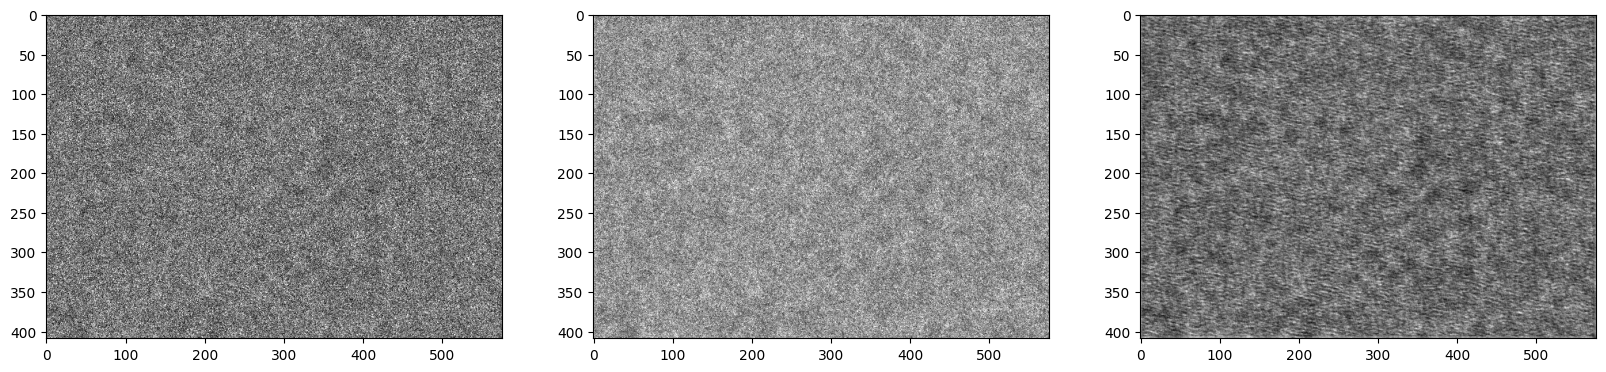

In [5]:
index = 0
show_each_tile(xx_test[index],ytrue_test[index], ypred_test[index], )

In [6]:

def recover_image(ypred):
    # Set the number of rows and columns in the grid
    num_rows = 10
    num_cols = 10

    # Initialize the empty grid
    grid = np.empty((num_rows, num_cols), dtype=object)
    
    directory = os.path.dirname(ypred)
    filename = ypred.replace(directory, "")
    ext = "." + filename.split(".")[-1]
    # Iterate over the subset images
    for i in range(100):
        fff = filename.split("__split")[0] + f"__split{i}" + ext
        # Load the subset image
        if ext==".npy":
            subset_image = np.load(directory + fff)
        elif ext==".mrc":
            with mrcfile.open(directory + fff) as mrc:
                subset_image = mrc.data
            
        # Determine the row and column indices in the grid
        row = i // num_cols
        col = i % num_cols

        # Assign the subset image to the corresponding grid position
        grid[row, col] = subset_image
    
    return concat_grid(grid)

def concat_grid(grid):
    row_list = [] 
    for i in range(grid.shape[0]):
        image = np.concatenate(grid[i, :], axis=1)
        row_list.append(image)
    return np.concatenate(row_list, axis=0)
    
def show_large_image(ypred_path):
    return recover_image(ypred_path)
    

# Large images

In [7]:
index = 520
xx_large = recover_image(xx_test[index])
ypred_large = recover_image(ypred_test[index])
ytrue_large = recover_image(ytrue_test[index])

Text(0.5, 1.0, 'low resolution')

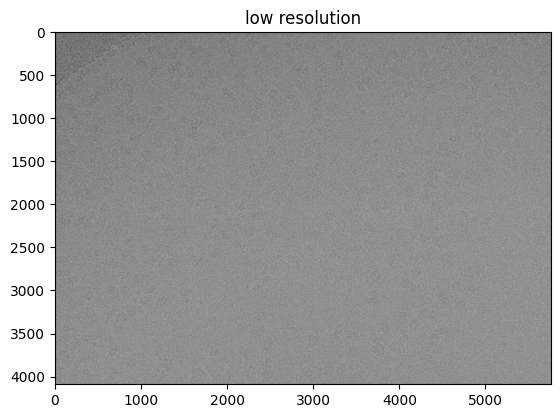

In [8]:
plt.imshow(xx_large, cmap="gray")
plt.title("low resolution")

Text(0.5, 1.0, 'ypred')

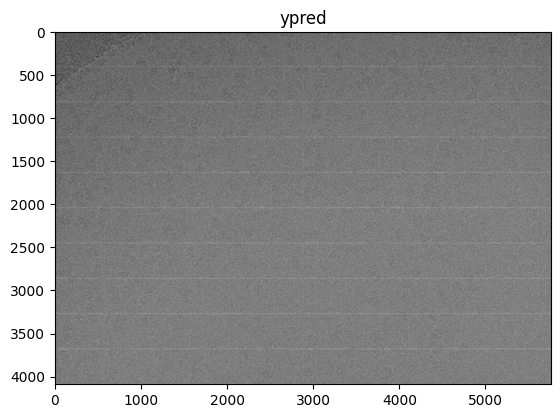

In [9]:
plt.imshow(ypred_large, cmap='gray', )
plt.title("ypred")

Text(0.5, 1.0, 'high resolution')

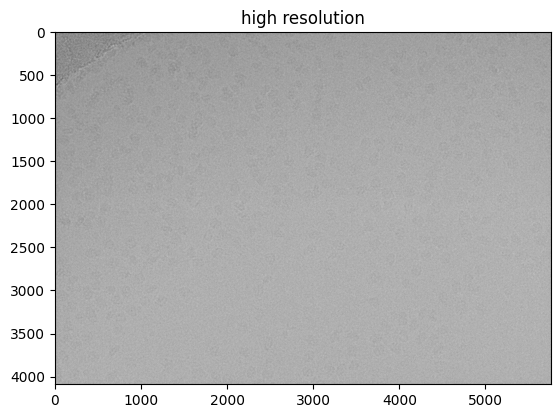

In [10]:
plt.imshow(ytrue_large, cmap='gray', )
plt.title("high resolution")